# Partiendo de los avances de Nerea

Se ha parametrizado:<br>
>timestep<br>
>valProportion: _para definir que % se deja para validación_<br>
>usedCols: _para seleccionar las columnas_<br>
>n_features: _se calcula partiendo de usedCols. La cantidad de columnas._<br>

<div class="alert alert-block alert-info">
Inspirado en:
__[Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)__
</div>

# 2017 - 12 - 13 intentando añadir el concepto timeDistributed



<div class="alert alert-block alert-info">
Inspirado en:
__[How to Use the TimeDistributed Layer for Long Short-Term Memory Networks in Python](https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/)__
</div>

El objetivo es predecir steps a futuro de una única variable.



In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import TimeDistributed


Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #print(data.shape[1])
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.iloc[:,-1].shift(-i))
        if i == 0:
            #names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            names += ['var(t)']
            #names += [('var%d(t)' % (n_vars+1))]
            
        else:
            #names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            names += [('var(t+%d)' % (i))]
            #names += [('var%d(t+%d)' % (n_vars+1))]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
futureSteps=2
timestep=5
valProportion=0.02
#usedCols=[ "LME_PR_AL_serie_MOM_15","LME_PR_AL_serie_ROC_7", "LME_PR_AL_serie_MOM_30", "OPEC_ORB_serie_ROC_7", "OPEC_ORB_serie_MOM_30", "OPEC_ORB_serie_ROC_30", "OPEC_ORB_serie_ROC_15", "LME_PR_AL_serie_close"]
usedCols=["LME_PR_AL_serie_MOM_15","LME_PR_AL_serie_ROC_7", "LME_PR_AL_serie_MOM_30", "OPEC_ORB_serie_ROC_7", "OPEC_ORB_serie_MOM_30", "OPEC_ORB_serie_ROC_30", "OPEC_ORB_serie_ROC_15","LME_PR_AL_serie_close"]
#usedCols=["LME_PR_AL_serie_close"]
n_features = len(usedCols)
print("n_features --> " + str(n_features))

n_features --> 8


In [4]:
# load dataset
dataset = read_csv('../data/data4.csv',usecols=usedCols)[usedCols]
values = dataset.values
reframed =  series_to_supervised(values,timestep, futureSteps)
# ensure all data is float
values = reframed.astype('float32')
values.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var(t),var(t+1)
35,-27.5,-0.005747,157.0,0.028574,7.23,0.043856,0.053568,2162.5,-12.5,0.000460,...,-80.5,-0.039901,68.5,0.023881,6.68,0.054965,0.071756,2129.5,2175.0,2211.0
36,-12.5,0.000460,122.0,0.028427,6.21,0.043717,0.060040,2173.0,-115.0,-0.053444,...,-82.0,-0.014499,38.0,0.017066,6.21,0.055713,0.077570,2175.0,2211.0,2228.5
37,-115.0,-0.053444,113.5,0.025612,5.13,0.052571,0.061270,2116.5,-114.0,-0.047043,...,-8.0,0.022428,77.0,0.036354,7.97,0.070309,0.090688,2211.0,2228.5,2252.5
38,-114.0,-0.047043,108.0,0.020041,6.36,0.054040,0.067321,2127.0,-80.5,-0.039901,...,28.5,0.025541,71.5,0.031796,8.76,0.088949,0.093744,2228.5,2252.5,2266.5
39,-80.5,-0.039901,68.5,0.023881,6.68,0.054965,0.071756,2129.5,-82.0,-0.014499,...,94.5,0.064257,143.0,0.040041,11.11,0.099812,0.083517,2252.5,2266.5,2307.5


In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
print(scaled[0])
print(scaled[1])



(1052, 42)
[ 0.35221907  0.0059844   0.73811321  0.53793993  0.7883423   0.57391248
  0.00231125  0.83597285  0.40471869  0.00649836  0.68528302  0.53757756
  0.78945129  0.58492562  0.00235549  0.84785068  0.21869328  0.00203537
  0.67245283  0.53063977  0.77488712  0.5966762   0.0023639   0.78393665
  0.22050817  0.00256531  0.66415094  0.51690933  0.79534785  0.59862587
  0.59679184  0.79581448  0.28130672  0.00315665  0.6045283   0.5263734
  0.79191919  0.55256679  0.60431501  0.79864253  0.85011312  0.8908371 ]
[ 0.38054769  0.00649836  0.68528302  0.53757756  0.76725921  0.57373165
  0.00235549  0.84785068  0.21869328  0.00203537  0.67245283  0.53063977
  0.76648234  0.5966762   0.0023639   0.78393665  0.22050817  0.00256531
  0.66415094  0.51690933  0.80133304  0.59862587  0.00240526  0.79581448
  0.28130672  0.00315665  0.6045283   0.5263734   0.8021767   0.59985462
  0.60431501  0.79864253  0.27858439  0.00525977  0.55849057  0.50957683
  0.78136925  0.55349788  0.61417587  0.

In [6]:
# specify the number of lag hours


# split into train and test sets
#values = reframed.values
#print(values.shape)
n_train_hours = round(scaled.shape[0] * (1-valProportion))
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]




print("train")
print (train.shape)
print("test")
print (test.shape)




train
(1031, 42)
test
(21, 42)


In [7]:
# split into input and outputs
#n_obs = 1000
# n_obs = n_hours

#print (train[:, -n_features])
train_X, train_y = train[:, :n_features*timestep], train[:,n_features*timestep:]
test_X, test_y = test[:, :n_features*timestep], test[:, n_features*timestep:]

print(train_X.shape, len(train_X), train_y.shape)



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timestep, n_features))
#train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))


test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
#test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
#model = Sequential()
#model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(n_features))
#model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
#model.summary()

model = Sequential()
model.add(LSTM(10, input_shape=(timestep, n_features), return_sequences=False))
#model.add(TimeDistributed(Dense(futureSteps)))
model.add(Dense(futureSteps))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['accuracy'])
print(model.summary())

(1031, 40) 1031 (1031, 2)
(1031, 5, 8) (1031, 2) (21, 5, 8) (21, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                760       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 782
Trainable params: 782
Non-trainable params: 0
_________________________________________________________________
None


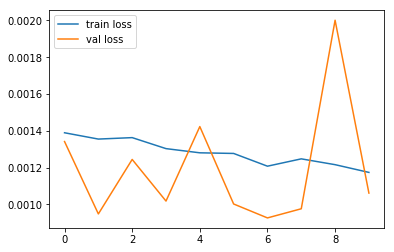

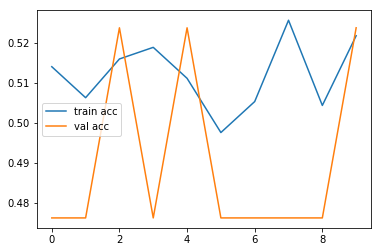

In [12]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=8, validation_data=(test_X, test_y), verbose=0, shuffle=True)

# plot history
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='val loss')
pyplot.legend()
pyplot.show()
# plot history
pyplot.plot(history.history['acc'], label='train acc')
pyplot.plot(history.history['val_acc'], label='val acc')
pyplot.legend()
pyplot.show()


In [13]:
#print(test_X[:1])
#print(model.predict(test_X[:1]))
#print(test_X[1:2])
#print(model.predict(test_X[1:2]))
predicted_data = []

for i in range(0,test_X.shape[0],futureSteps):
  predicted_data.append( model.predict(test_X[i:i+1]))

print(predicted_data)

[array([[ 0.79973555,  0.82480466]], dtype=float32), array([[ 0.79152334,  0.8043415 ]], dtype=float32), array([[ 0.80662286,  0.82684553]], dtype=float32), array([[ 0.80655587,  0.81319034]], dtype=float32), array([[ 0.82540178,  0.83718151]], dtype=float32), array([[ 0.81286335,  0.81802303]], dtype=float32), array([[ 0.820979  ,  0.83692658]], dtype=float32), array([[ 0.82468247,  0.83693391]], dtype=float32), array([[ 0.81631899,  0.82900524]], dtype=float32), array([[ 0.77451432,  0.78122348]], dtype=float32), array([[ 0.75648785,  0.7888841 ]], dtype=float32)]


(21, 2)


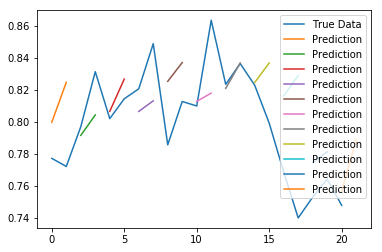

In [14]:
import matplotlib.pyplot as plt
import numpy as np
print (test_y.shape)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(test_y[:,0], label='True Data')

#Pad the list of predictions to shift it in the graph to it's correct start
for i, data in enumerate(predicted_data):
    padding = [None for p in range(i * futureSteps)]
    x = np.array(padding)
    #print(x.shape)
    #print(predicted_data[i][0])
    y = np.array(predicted_data[i][0])
    #print(y.shape)
    
    
    #print(np.append(x , y))
    
    plt.plot(np.append(x , y), label='Prediction')
    plt.legend()
plt.show()

In [11]:
'''print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], timestep, n_features))
print(test_X.shape)
# make a prediction
yhat = model.predict(test_X)
print("yhat.shape -->" + str(yhat.shape))
test_X = test_X.reshape((test_X.shape[0], timestep*n_features))
print(test_X.shape)

# invert scaling for forecast
print(yhat.shape)
inv_yhat = concatenate((yhat, test_X[:, -n_features:]), axis=1)
print("inv_hat")
print(inv_yhat)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#rmse = sqrt(mean_squared_error(yhat, test_X[:, -1:]))
print('Test RMSE: %.3f' % rmse)'''

'print(test_X.shape)\ntest_X = test_X.reshape((test_X.shape[0], timestep, n_features))\nprint(test_X.shape)\n# make a prediction\nyhat = model.predict(test_X)\nprint("yhat.shape -->" + str(yhat.shape))\ntest_X = test_X.reshape((test_X.shape[0], timestep*n_features))\nprint(test_X.shape)\n\n# invert scaling for forecast\nprint(yhat.shape)\ninv_yhat = concatenate((yhat, test_X[:, -n_features:]), axis=1)\nprint("inv_hat")\nprint(inv_yhat)\n\ninv_yhat = scaler.inverse_transform(inv_yhat)\ninv_yhat = inv_yhat[:,0]\n#invert scaling for actual\ntest_y = test_y.reshape((len(test_y), 1))\ninv_y = concatenate((test_y, test_X[:, -7:]), axis=1)\ninv_y = scaler.inverse_transform(inv_y)\ninv_y = inv_y[:,0]\n# calculate RMSE\nrmse = sqrt(mean_squared_error(inv_y, inv_yhat))\n#rmse = sqrt(mean_squared_error(yhat, test_X[:, -1:]))\nprint(\'Test RMSE: %.3f\' % rmse)'